# <span style='color:red'>Quantitative Investing with Python</span>

### Professor Juhani Linnainmaa

Dartmouth College and Kepos Capital

*Last revised:* February 1, 2025

--- 

# **Topic 7:** Neural Networks

## Learning Objective

How to code up a feedforward neural network in TenserFlow to predict stock returns

- Use the same Compustat/CRSP dataset as in Topics 5 and 6
- Same features

This notebook builds on a set of QIP slides and ```A Neural Network Playground``` exercise

## Plan

1. Set up a simple FFNN with two hidden layers with 64 and 32 neurons and ReLU activation functions

   - Examine the performance of this neural network in the training and validation samples<br><br>
   
2. Change the network architecture for robustness
   - Add a 30% drop-out rate fron one layer to the next (robustness)
   - Add L2 normalization ("ridge penalty" for robustness)
   - Three layers: 64-32-16 (intuition for what is a more reasonable structure?)
   - Set epochs = 100 but with early termination  
   
   Examine the performance of this neural network in the training and validation samples

In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import KFold, GroupKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

In [ ]:
cs_crsp = pd.read_pickle('/home/jovyan/data/ml_crsp.pkl')

first_train_date, last_train_date = '1963-06', '1990-12'
first_validation_date, last_validation_date = '1991-01', '2000-12'
first_test_date, last_test_date = '2001-01', '2010-12'

train_dates = pd.date_range(first_train_date, last_train_date, freq='MS')
validation_dates = pd.date_range(first_validation_date, last_validation_date, freq='MS')
test_dates  = pd.date_range(first_test_date, last_test_date, freq='MS')

# the TARGET variable is the return next month
cs_crsp['retnm'] = cs_crsp.groupby(level='permno')['ret'].shift(-1)

# The FIRST set of features consist of monthly returns over the past year
for lag in range(12):
    cs_crsp['x0_retlag' + str(lag)] = cs_crsp.groupby(level='permno')['ret'].shift(lag)
    
# The SECOND set of features are (a) log-size, (b) log-BE/ME, (c) log-asset growth, and (d) gross profitability

# (1) log-size
cs_crsp['x1_logme'] = np.log(cs_crsp['me'])

# (2) log-book-to-market
cs_crsp['be'] = cs_crsp['be'].apply(lambda x: x if x > 0 else np.nan) # set negative BEs to missing
cs_crsp['beme'] = cs_crsp['be'] / cs_crsp['me']
cs_crsp['x2_logbeme'] = np.log(cs_crsp['beme'])

# (3) asset growth
cs_crsp['at_lag12'] = cs_crsp.groupby(level='permno')['at'].shift(12)
cs_crsp['x3_log_asset_growth'] = np.log(cs_crsp['at'] / cs_crsp['at_lag12'])
bad_data = (cs_crsp['at'] <= 0) | (cs_crsp['at_lag12'] <= 0) 
cs_crsp.loc[bad_data, 'x3_log_asset_growth'] = np.nan

# (4) gross profitability
cs_crsp['x4_gross_profitability'] = (cs_crsp['sale'] - cs_crsp['cogs']) / cs_crsp['at']
bad_data = cs_crsp['at'] <= 0 
cs_crsp.loc[bad_data, 'x4_gross_profitability'] = np.nan

# Keep only the variables we need
target_var = ['retnm']
features = [c for c in cs_crsp.columns if c.startswith('x')]
cs_crsp = cs_crsp[target_var + features]

# Normalize variable by cross-sectionally demeaning
cs_crsp = cs_crsp.sub(cs_crsp.groupby(level='date').mean(), level='date')

In [ ]:
# 1. Select features and target
feature_cols = features[:]
target_col = 'retnm'

train_rows = cs_crsp.index.get_level_values(level='date').isin(train_dates)
train_data = cs_crsp[train_rows].dropna()

X_train = train_data[feature_cols].values
y_train = train_data[target_col].values

# 3. Scale features (important for neural networks)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# 4. Define a simple neural network
model = keras.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)  # single output neuron for regression
])

# 5. Compile the model
#    Using mean squared error as a basic loss for regression
model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mean_absolute_error']
)

# 6. Train the model
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,   # further splits training data for validation
    epochs=50,
    batch_size=256,
    verbose=1
)

# 8. Make predictions
train_data['pred_retnm'] = model.predict(X_train_scaled)

In [ ]:
def compute_strategy_returns(df):
    """
    A function for computing the return on a rank-weighted portfolio based on 'pret_retnm' field
    Pay attention to the timing convention!
    """    
    df = df.copy()
    df['position'] = (1/30) * (
        df.groupby(level='date')['pred_retnm']  # Group by the 'date' level in the index
        .transform(lambda x: (x.rank() - x.rank().min()) / (x.rank().max() - x.rank().min()) * 2 - 1)
    )

    position = df['position'].unstack(level='permno').sort_index()
    retnm = df['retnm'].unstack(level='permno').sort_index()

    strategy_returns = position.mul(retnm).sum(axis=1, min_count=1)
    strategy_returns = strategy_returns.shift(1) # undo timing, that is, the fact that we compute returns based on the return the NEXT month
    
    return strategy_returns

In [ ]:
def analyze_returns(r=None, name=None):
    start_date, end_date = r.index.min(), r.index.max()
    ir = np.sqrt(12) * r.mean() / r.std()
    print(f'Start: {start_date:%b %Y}, End: {end_date:%b %Y}')
    print(f'Sharpe ratio: {ir:.2f}')
    r.cumsum().plot(figsize=(12,8), title=name)

In [ ]:
training_returns = compute_strategy_returns(train_data)
analyze_returns(r=training_returns, name='Neural network predictions in the training sample')

In [ ]:
validation_rows = cs_crsp.index.get_level_values(level='date').isin(validation_dates)
validation_data = cs_crsp[validation_rows].dropna()

X_validation = validation_data[feature_cols].values

# 3. Scale features (important for neural networks)
X_validation_scaled = scaler.fit_transform(X_validation)

validation_data['pred_retnm'] = model.predict(X_validation_scaled)

training_returns = compute_strategy_returns(validation_data)
analyze_returns(r=training_returns, name='Neural network predictions in the validation sample')

In [ ]:
# 1. Select features and target
feature_cols = features[:]
target_col = 'retnm'

train_rows = cs_crsp.index.get_level_values(level='date').isin(train_dates)
train_data = cs_crsp[train_rows].dropna()

X_train = train_data[feature_cols].values
y_train = train_data[target_col].values

# 3. Scale features (important for neural networks)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Define the number of input features
input_dim = X_train_scaled.shape[1]

# regularization: L2 norm
reg_val = 0.01

# 4. Define a neural network with dropout and batch normalization
model = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(reg_val)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(reg_val)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(reg_val)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1)
])

# 5. Compile the model
#    Using mean squared error as a basic loss for regression
model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mean_absolute_error']
)

# 5. Train the model (with early stopping)
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True
)
history = model.fit(
    X_train_scaled, 
    y_train,
    validation_split=0.2,  # splits training data for internal validation
    epochs=100,
    batch_size=256,
    callbacks=[callback],
    verbose=1
)

# 8. Make predictions
train_data['pred_retnm'] = model.predict(X_train_scaled)

In [ ]:
training_returns = compute_strategy_returns(train_data)
analyze_returns(r=training_returns, name='Neural network predictions in the training sample')

In [ ]:
X_validation = validation_data[feature_cols].values
X_validation_scaled = scaler.fit_transform(X_validation)

validation_data['pred_retnm'] = model.predict(X_validation_scaled)

validation_returns = compute_strategy_returns(validation_data)
analyze_returns(r=validation_returns, name='Neural network predictions in the validation sample')

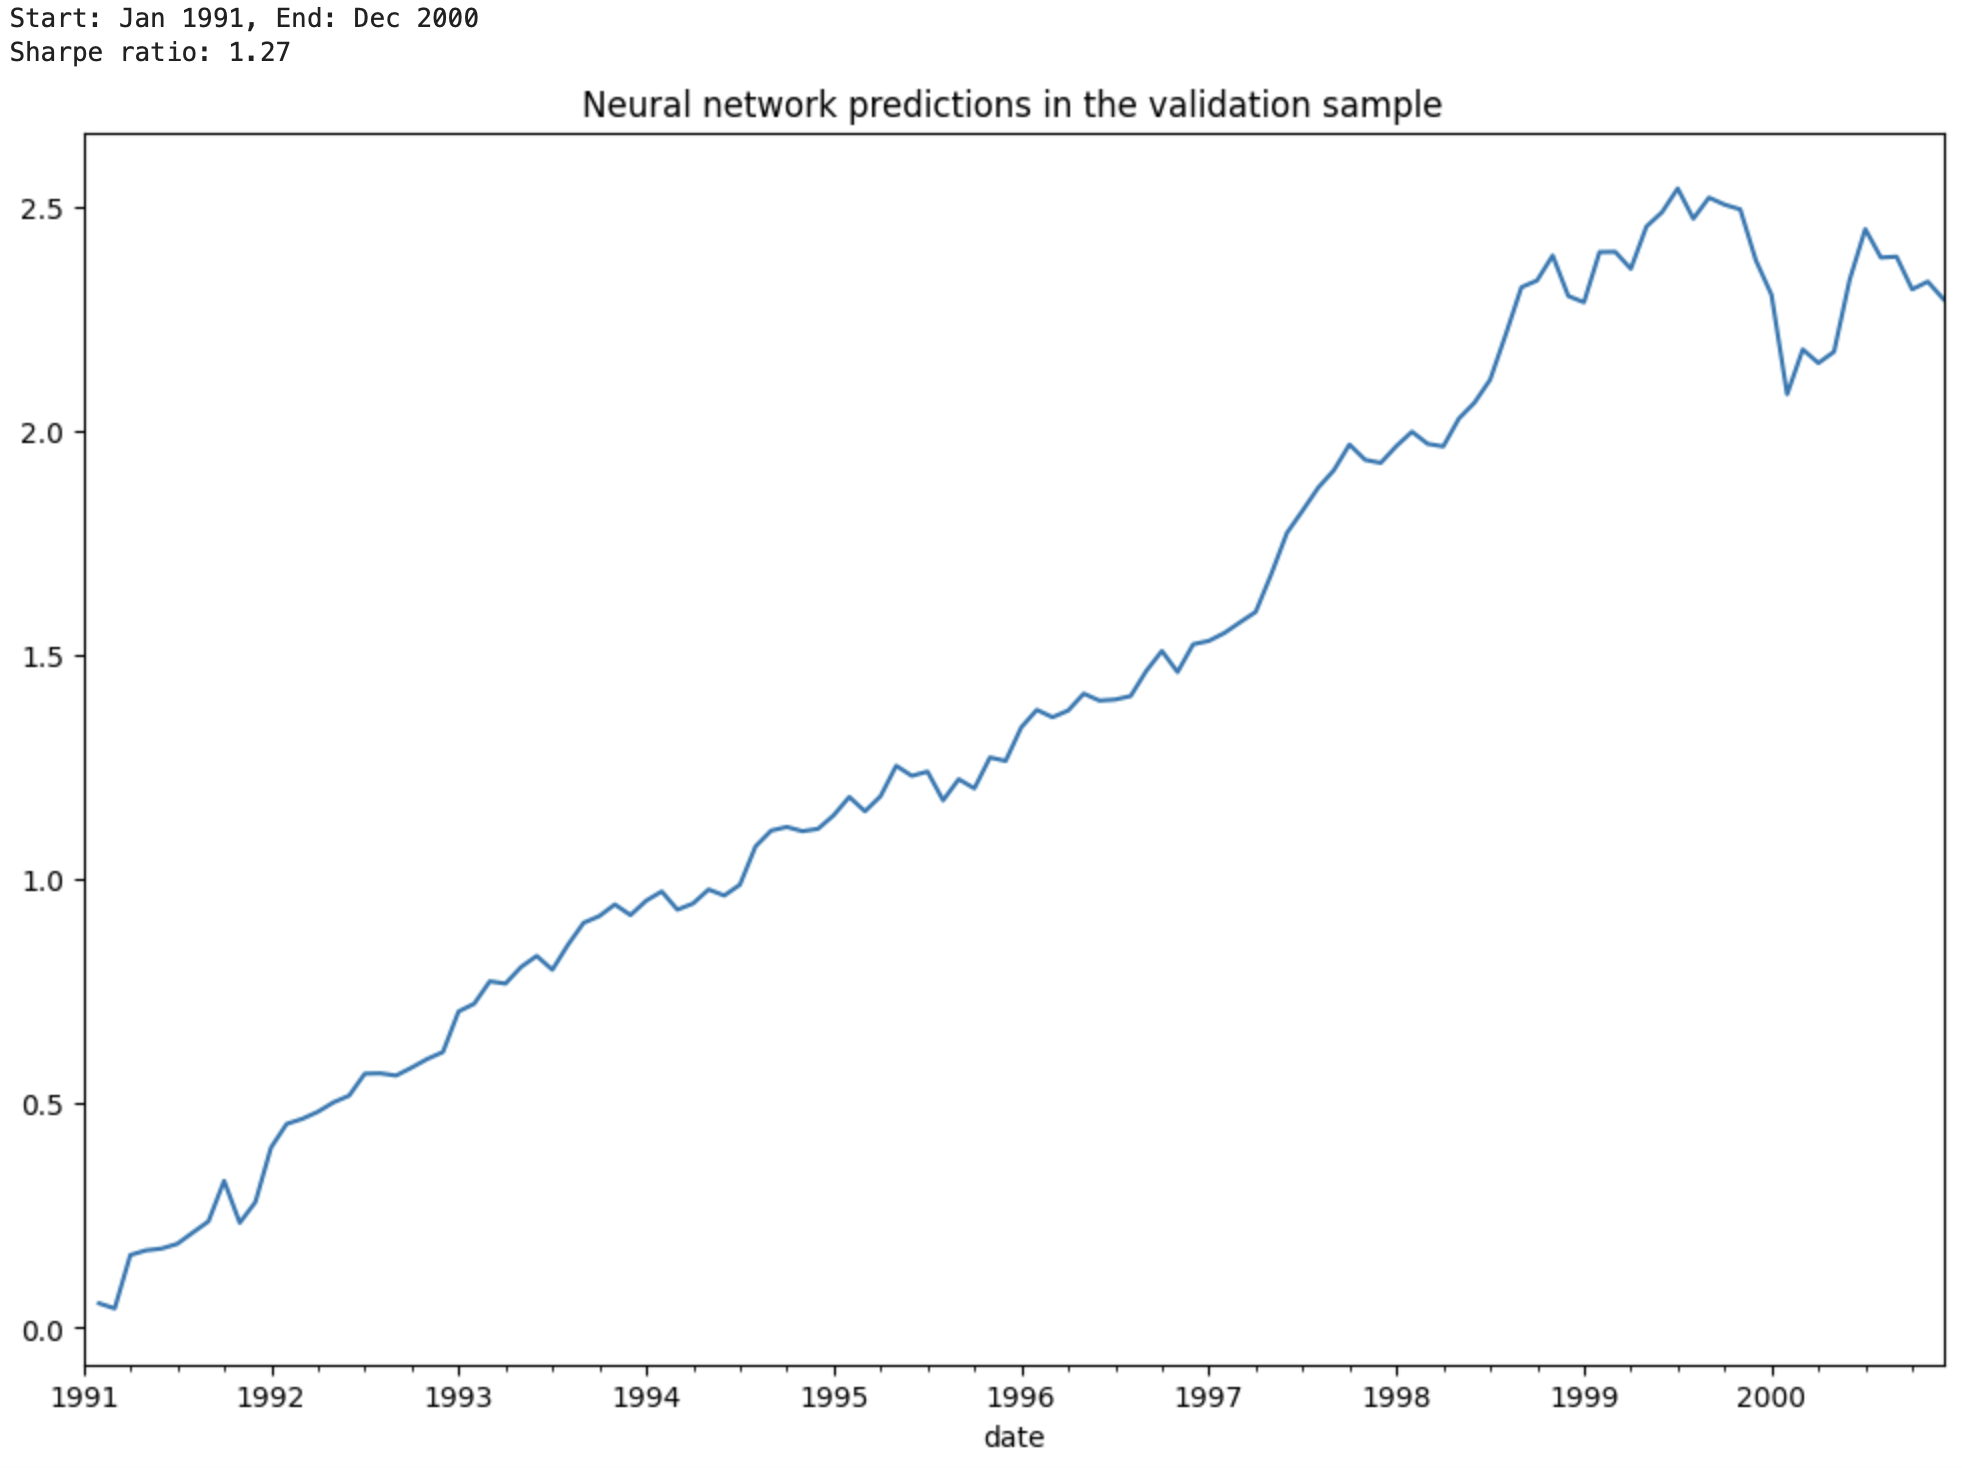